In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##1.Import thư viện

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.despine()
plt.style.use("fivethirtyeight")
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
import emoji
from wordcloud import WordCloud, STOPWORDS
import re,string, nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.snowball import SnowballStemmer
import warnings

<Figure size 640x480 with 0 Axes>

##2.Dataset


In [ ]:
#import dữ liệu
df =  pd.read_csv('cyberbullying_tweets.csv')


df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [ ]:
print(f"Data có {df.shape[0]} hàng và {df.shape[1]} cột.")

Data có 59621 hàng và 2 cột.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59621 entries, 0 to 59620
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          59621 non-null  object
 1   cyberbullying_type  59621 non-null  object
dtypes: object(2)
memory usage: 931.7+ KB


In [ ]:
#Phần trăm số lượng null
(df.isna().sum())/(len(df))

tweet_text            0.0
cyberbullying_type    0.0
dtype: float64

In [ ]:
df = df.rename(columns={"tweet_text":"text","cyberbullying_type":"sentiment"})

In [ ]:
df.sentiment.value_counts()

ethnicity              15922
age                    11960
religion                7998
gender                  7973
not_cyberbullying       7945
other_cyberbullying     7823
Name: sentiment, dtype: int64

##3.Data preprocessing

In [ ]:
df["text"].duplicated().sum()

13603

In [ ]:
df.drop_duplicates("text", inplace=True)

In [ ]:
df.sentiment.value_counts()

age                    7993
religion               7991
ethnicity              7957
not_cyberbullying      7937
gender                 7897
other_cyberbullying    6243
Name: sentiment, dtype: int64

In [ ]:
# function for cleaning tweets
def clean_tweet(df,field):
    #remove links and mentions
    df[field] = df[field].str.replace(r"http\S+"," ")
    df[field] = df[field].str.replace(r"http"," ")
    df[field] = df[field].str.replace(r"@","at")
    #remove hashtag
    df[field] = df[field].str.replace("#[A-Za-z0-9_]+", ' ')
    # thay thế các ký tự không phải chữ cái và ký tự đặc biệt đặc biệt thành khoảng trắng
    df[field] = df[field].str.replace(r"[^A-Za-z(),!?@\'\"_\n]"," ")
    #viết thường
    df[field] = df[field].str.lower()
    return df

In [ ]:
clean_tweet(df,"text")

<ipython-input-35-cdd322674f1e>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df[field] = df[field].str.replace(r"http\S+"," ")
<ipython-input-35-cdd322674f1e>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df[field] = df[field].str.replace("#[A-Za-z0-9_]+", ' ')
<ipython-input-35-cdd322674f1e>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df[field] = df[field].str.replace(r"[^A-Za-z(),!?@\'\"_\n]"," ")


,text,sentiment
0,"in other words , your food was crapilicious!",not_cyberbullying
1,why is so white?,not_cyberbullying
2,atxochitlsuckkks a classy whore? or more red v...,not_cyberbullying
3,"atjason_gio meh p thanks for the heads up, ...",not_cyberbullying
4,atrudhoeenglish this is an isis account preten...,not_cyberbullying
...,...,...
47688,"why is everyone so soft, if this girl was gett...",age
47689,just a reminder that defunding the police mean...,age
47690,last night i had a nightmare that the girls wh...,age
47691,vandal savage had the same relationship with g...,age


In [ ]:
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from wordcloud import WordCloud, STOPWORDS

# Applying Lemmmatizer to remove tenses from texts.
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")
STOPWORDS.update(['rt', 'mkr', 'didn', 'bc', 'n', 'm',
                  'im', 'll', 'y', 've', 'u', 'ur', 'don',
                  'p', 't', 's', 'aren', 'kp', 'o', 'kat',
                  'de', 're', 'amp', 'will'])


In [ ]:
corpus = []
def preprocess_tweet(tweet):
    #remove contractions
    tweet = re.sub(r"won\'t", "will not", tweet)
    tweet = re.sub(r"can\'t", "can not", tweet)
    tweet = re.sub(r"n\'t", " not", tweet)
    tweet = re.sub(r"\'re", " are", tweet)
    tweet = re.sub(r"\'s", " is", tweet)
    tweet = re.sub(r"\'d", " would",tweet)
    tweet = re.sub(r"\'ll", " will", tweet)
    tweet = re.sub(r"\'t", " not", tweet)
    tweet = re.sub(r"\'ve", " have", tweet)
    tweet = re.sub(r"\'m", " am", tweet)
    tweet = re.sub('[^a-zA-Z]',' ',tweet)
    #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    tweet = re.sub(r'[^\x00-\x7f]','',tweet)

    #Stemming
    tweet = " ".join([stemmer.stem(word) for word in tweet.split()])
    #Lemmatization
    tweet = [lemmatizer.lemmatize(word) for word in tweet.split() if not word in set(STOPWORDS)]
    tweet = ' '.join(tweet)
    return tweet

df["text_clean"] = df["text"].apply(preprocess_tweet)

<ipython-input-57-ac9180097749>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_clean"] = df["text"].apply(preprocess_tweet)


In [ ]:
# xóa bỏ nhãn không có giá trị
df = df[df["sentiment"]!="other_cyberbullying"]

In [ ]:
df.shape

(39775, 3)

In [ ]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [ ]:
df['text_len'] = text_len

<ipython-input-59-5bfdd5f14fa3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_len'] = text_len


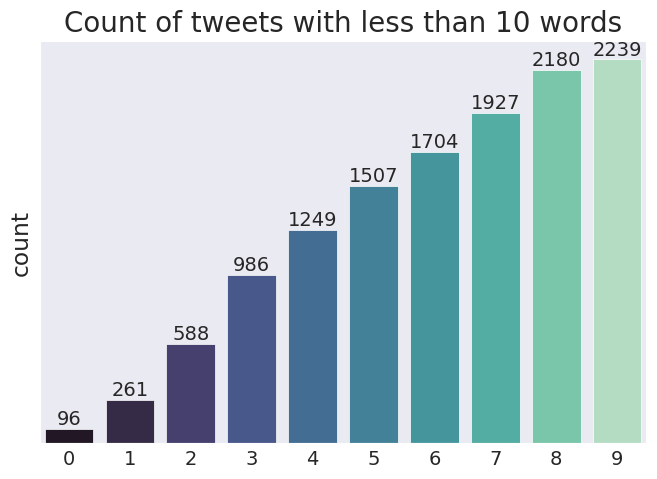

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [ ]:
# kiểm tra độ dài chuỗi
df.sort_values(by=['text_len'], ascending=False)

,text,sentiment,text_clean,text_len
17782,you so black and white trying to live like a n...,ethnicity,black white tri live nigger pahahahaha common ...,183
18912,"athermdiggz attayyoung_ fuck obama, dumb as...",ethnicity,athermdiggz attayyoung fuck obama dumb as nigg...,157
1317,ateurekalertaaas researchers push to import t...,not_cyberbullying,ateurekalertaaa research push import top anti ...,146
45653,"i don't feel guilty for killing him, i jus...",age,feel guilti kill feel guilti becaus enjoy torm...,138
22851,don't make rape jokes!!! don't make gay jokes!...,gender,make rape joke make gay joke oh fat joke okay ...,137
...,...,...,...,...
7486,,not_cyberbullying,,0
24571,,gender,,0
3167,,not_cyberbullying,,0
3172,,not_cyberbullying,,0


#Xóa bỏ outlines

In [ ]:
df = df[df['text_len'] > 3]
df = df[df['text_len'] < 100]

In [ ]:
df

,text,sentiment,text_clean,text_len
2,atxochitlsuckkks a classy whore? or more red v...,not_cyberbullying,atxochitlsuckkk classi whore red velvet cupcak,6
3,"atjason_gio meh p thanks for the heads up, ...",not_cyberbullying,atjason gio meh thank head concern anoth angri...,10
4,atrudhoeenglish this is an isis account preten...,not_cyberbullying,atrudhoeenglish isi account pretend kurdish ac...,8
5,"atraja aab atquickieleaks yes, the test of god...",not_cyberbullying,atraja aab atquickieleak yes test god good bad...,14
6,itu sekolah ya bukan tempat bully! ga jauh kay...,not_cyberbullying,itu sekolah ya bukan tempat bulli ga jauh kaya...,10
...,...,...,...,...
47688,"why is everyone so soft, if this girl was gett...",age,whi everyon soft girl bulli respons give high ...,10
47689,just a reminder that defunding the police mean...,age,remind defund polic mean shift toward fund com...,28
47690,last night i had a nightmare that the girls wh...,age,last night nightmar girl bulli vicious middl h...,22
47691,vandal savage had the same relationship with g...,age,vandal savag relationship grant emerson leela ...,25


In [ ]:
df['tweet_list'] = df['text_clean'].apply(lambda x:str(x).split())
top = Counter([item for sublist in df['tweet_list'] for item in sublist])
tweet_list1 = pd.DataFrame(top.most_common(20))
tweet_list1.columns = ['Words','Count']
tweet_list1.style.background_gradient(cmap='Greens')

,Words,Count
0,bulli,10225
1,school,9134
2,fuck,7341
3,nigger,5705
4,joke,5579
5,girl,5521
6,dumb,5311
7,high,5240
8,muslim,4927
9,rape,4637


In [ ]:
figure = px.bar(tweet_list1, x="Count", y="Words", title='Top 20 words in cyberbullying tweet', orientation='h',
             width=700, height=700,color='Words')
figure.show()

In [ ]:
not_cyberbullying_type = df[df['sentiment']=='not_cyberbullying']
gender_type = df[df['sentiment']=='gender']
religion_type = df[df['sentiment']=='religion']

age_type = df[df['sentiment']=='age']
ethnicity_type = df[df['sentiment']=='ethnicity']

In [ ]:
#Top 10 Words in not cyberbullying Tweet
top20 = Counter([item for sublist in not_cyberbullying_type['tweet_list'] for item in sublist])
type_nc = pd.DataFrame(top20.most_common(10))
type_nc.columns = ['Top of Words','Count']
type_nc.style.background_gradient(cmap='Greens')

,Top of Words,Count
0,bulli,1115
1,go,368
2,school,346
3,peopl,268
4,one,263
5,think,232
6,know,227
7,time,217
8,make,213
9,now,205


In [ ]:
nc_fig = px.bar(type_nc, x="Count", y="Top of Words", title='Top 10 Words in not cyberbullying Tweet', orientation='h',
             width=700, height=700,color='Top of Words')
nc_fig.show()

In [ ]:
#Top 20 Words in Gender cyberbullying Tweet
top20_gender = Counter([item for sublist in gender_type['tweet_list'] for item in sublist])
type_g = pd.DataFrame(top20_gender.most_common(10))
type_g.columns = ['Top of Words','Count']
type_g.style.background_gradient(cmap='Greens')

,Top of Words,Count
0,joke,5386
1,rape,4377
2,gay,4141
3,call,1403
4,make,1345
5,woman,1200
6,bitch,1146
7,femal,1128
8,peopl,1007
9,sexist,969


In [ ]:
g_fig = px.bar(type_g, x="Count", y="Top of Words", title='Top 20 Words in Gender Cyberbullying Tweet', orientation='h',
             width=700, height=700,color='Top of Words')
g_fig.show()

In [ ]:
#Top 10 Words in religion cyberbullying Tweet
top20_r = Counter([item for sublist in religion_type['tweet_list'] for item in sublist])
type_r = pd.DataFrame(top20_r.most_common(10))
type_r.columns = ['Top of Words','Count']
type_r.style.background_gradient(cmap='Greens')

,Top of Words,Count
0,muslim,4802
1,idiot,3100
2,islam,2368
3,christian,2183
4,terrorist,1404
5,right,1343
6,woman,1272
7,support,1270
8,terror,1242
9,radic,1123


In [ ]:
r_fig = px.bar(type_r, x="Count", y="Top of Words", title='Top 20 Words in Religion Cyberbullying Tweet', orientation='h',
             width=700, height=700,color='Top of Words')
r_fig.show()

In [ ]:
#Top 10 Words in Age Cyberbullying Tweet
top10_a = Counter([item for sublist in age_type['tweet_list'] for item in sublist])
type_a = pd.DataFrame(top10_a.most_common(10))
type_a.columns = ['Top of Words','Count']
type_a.style.background_gradient(cmap='Greens')

,Top of Words,Count
0,bulli,9020
1,school,8572
2,high,5072
3,girl,4697
4,one,1051
5,peopl,935
6,now,912
7,becaus,854
8,got,825
9,kid,815


In [ ]:
a_fig = px.bar(type_a, x="Count", y="Top of Words", title='Top 20 Words in Age cyberbullying Tweet', orientation='h',
             width=700, height=700,color='Top of Words')
a_fig.show()

In [ ]:
#Top 10 Words in Ethnicity Cyberbullying Tweet
top10_e = Counter([item for sublist in ethnicity_type['tweet_list'] for item in sublist])
type_e = pd.DataFrame(top10_e.most_common(10))
type_e.columns = ['Top of Words','Count']
type_e.style.background_gradient(cmap='Greens')

,Top of Words,Count
0,fuck,6057
1,nigger,5701
2,dumb,5151
3,as,2298
4,black,2193
5,white,1600
6,call,1386
7,peopl,1191
8,obama,1129
9,one,1074


In [ ]:
e_fig = px.bar(type_e, x="Count", y="Top of Words", title='Top 10 Words in Ethnicity Cyberbullying Tweet', orientation='h',
             width=700, height=700,color='Top of Words')
e_fig.show()

##Turning text into numbers

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline


tfidf = TfidfTransformer()
clf = CountVectorizer()

X_cv =  clf.fit_transform(df['text_clean'])

tf_transformer = TfidfTransformer(use_idf=True).fit(X_cv)
X_tf = tf_transformer.transform(X_cv)

In [ ]:
X_tf

<37836x36747 sparse matrix of type '<class 'numpy.float64'>'
	with 508549 stored elements in Compressed Sparse Row format>

##Chia tập train test

In [ ]:
from sklearn.model_selection import train_test_split
# train and test
X_train, X_test, y_train, y_test = train_test_split(X_tf, df['sentiment'], test_size=0.20, stratify=df['sentiment'], random_state=42)

In [ ]:
y_train.value_counts()

religion             6353
age                  6329
ethnicity            6297
gender               6034
not_cyberbullying    5255
Name: sentiment, dtype: int64

##Cân bằng dữ liệu

In [ ]:
from imblearn.over_sampling import SMOTE
vc = y_train.value_counts()
while (vc[0] != vc[4]) or (vc[0] !=  vc[2]) or (vc[0] !=  vc[3]) or (vc[0] !=  vc[1]):
    smote = SMOTE(sampling_strategy='minority')
    X_train, y_train = smote.fit_resample(X_train, y_train)
    vc = y_train.value_counts()

y_train.value_counts()

ethnicity            6353
religion             6353
gender               6353
not_cyberbullying    6353
age                  6353
Name: sentiment, dtype: int64

#3.Model

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)

MultinomialNB()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
from sklearn.svm import SVC

svc_clf = SVC()

svc_clf.fit(X_train, y_train)

SVC()

#4.Kết quả

In [ ]:
from sklearn.metrics import classification_report
sentiments = ["religion","age","gender","ethnicity","not bullying"]
nb_pred = nb_clf.predict(X_test)
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred, target_names=sentiments))

Classification Report for Naive Bayes:
               precision    recall  f1-score   support

    religion       0.75      0.99      0.85      1582
         age       0.91      0.89      0.90      1575
      gender       0.89      0.86      0.88      1509
   ethnicity       0.88      0.44      0.59      1314
not bullying       0.84      0.97      0.90      1588

    accuracy                           0.84      7568
   macro avg       0.85      0.83      0.82      7568
weighted avg       0.85      0.84      0.83      7568



In [ ]:
knn_pred = knn_clf.predict(X_test)
print('Classification Report for Naive Bayes:\n',classification_report(y_test, knn_pred, target_names=sentiments))

Classification Report for Naive Bayes:
               precision    recall  f1-score   support

    religion       0.93      0.68      0.78      1582
         age       0.93      0.74      0.82      1575
      gender       0.82      0.78      0.80      1509
   ethnicity       0.36      0.87      0.51      1314
not bullying       0.93      0.35      0.50      1588

    accuracy                           0.67      7568
   macro avg       0.79      0.68      0.68      7568
weighted avg       0.81      0.67      0.69      7568



In [ ]:
rf_pred = rf_clf.predict(X_test)
print('Classification Report for Random Forest:\n',classification_report(y_test, rf_pred, target_names=sentiments))

Classification Report for Random Forest:
               precision    recall  f1-score   support

    religion       0.98      0.98      0.98      1582
         age       0.99      0.99      0.99      1575
      gender       0.95      0.88      0.91      1509
   ethnicity       0.81      0.88      0.85      1314
not bullying       0.96      0.96      0.96      1588

    accuracy                           0.94      7568
   macro avg       0.94      0.94      0.94      7568
weighted avg       0.94      0.94      0.94      7568



In [ ]:
dt_pred = dt_clf.predict(X_test)
print('Classification Report for Decision Tree:\n',classification_report(y_test, dt_pred, target_names=sentiments))

Classification Report for Decision Tree:
               precision    recall  f1-score   support

    religion       0.97      0.98      0.98      1582
         age       0.98      0.97      0.98      1575
      gender       0.90      0.89      0.89      1509
   ethnicity       0.79      0.81      0.80      1314
not bullying       0.94      0.94      0.94      1588

    accuracy                           0.92      7568
   macro avg       0.92      0.92      0.92      7568
weighted avg       0.92      0.92      0.92      7568



In [ ]:
svc_pred = svc_clf.predict(X_test)
print('Classification Report for SVC:\n',classification_report(y_test, svc_pred, target_names=sentiments))

Classification Report for SVC:
               precision    recall  f1-score   support

    religion       0.96      0.98      0.97      1582
         age       0.98      0.98      0.98      1575
      gender       0.97      0.85      0.91      1509
   ethnicity       0.77      0.88      0.82      1314
not bullying       0.96      0.94      0.95      1588

    accuracy                           0.93      7568
   macro avg       0.93      0.93      0.93      7568
weighted avg       0.93      0.93      0.93      7568



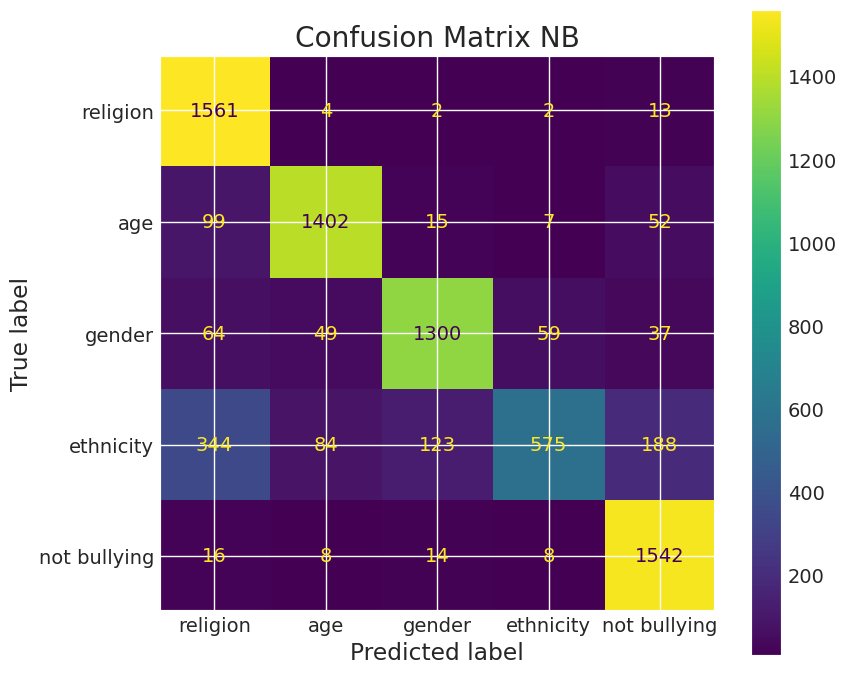

In [ ]:
# Naive Bayes
cm = confusion_matrix(y_test,nb_pred)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(cm, display_labels=sentiments)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.title("Confusion Matrix NB")
plt.show()

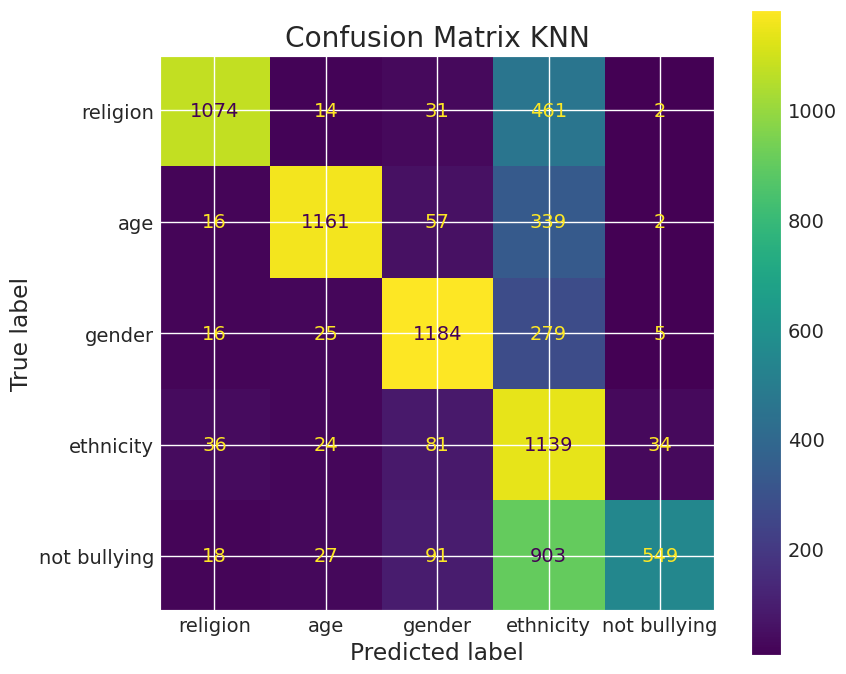

In [ ]:
# KNN
cm = confusion_matrix(y_test,knn_pred)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(cm, display_labels=sentiments)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.title("Confusion Matrix KNN")
plt.show()

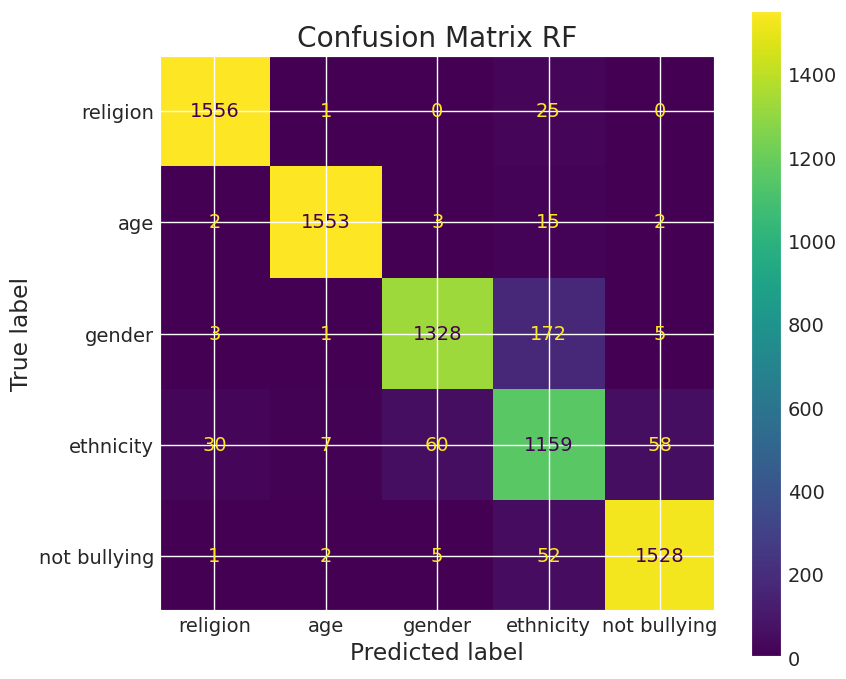

In [ ]:
# RF
cm = confusion_matrix(y_test,rf_pred)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(cm, display_labels=sentiments)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.title("Confusion Matrix RF")
plt.show()

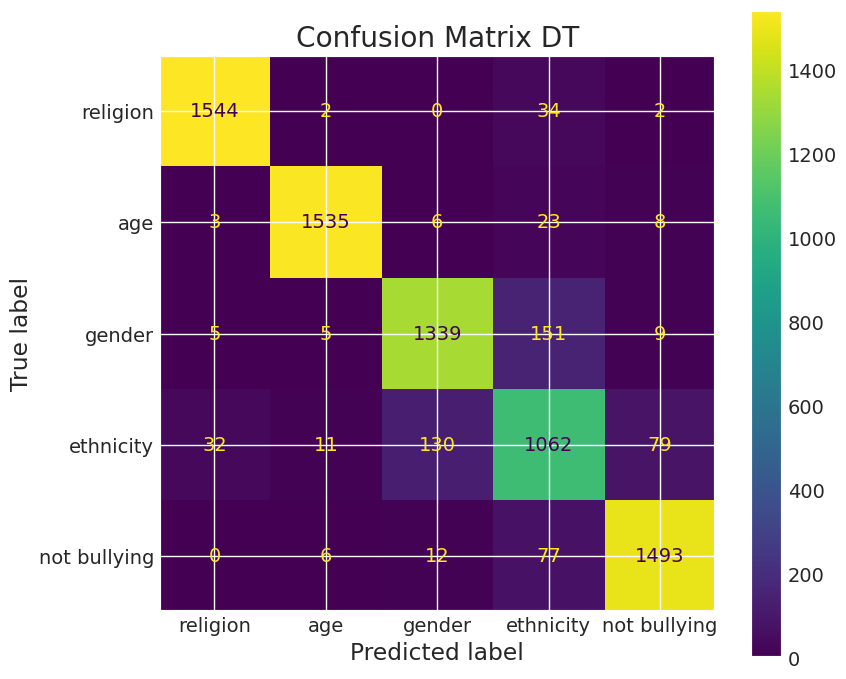

In [ ]:
# DT
cm = confusion_matrix(y_test,dt_pred)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(cm, display_labels=sentiments)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.title("Confusion Matrix DT")
plt.show()

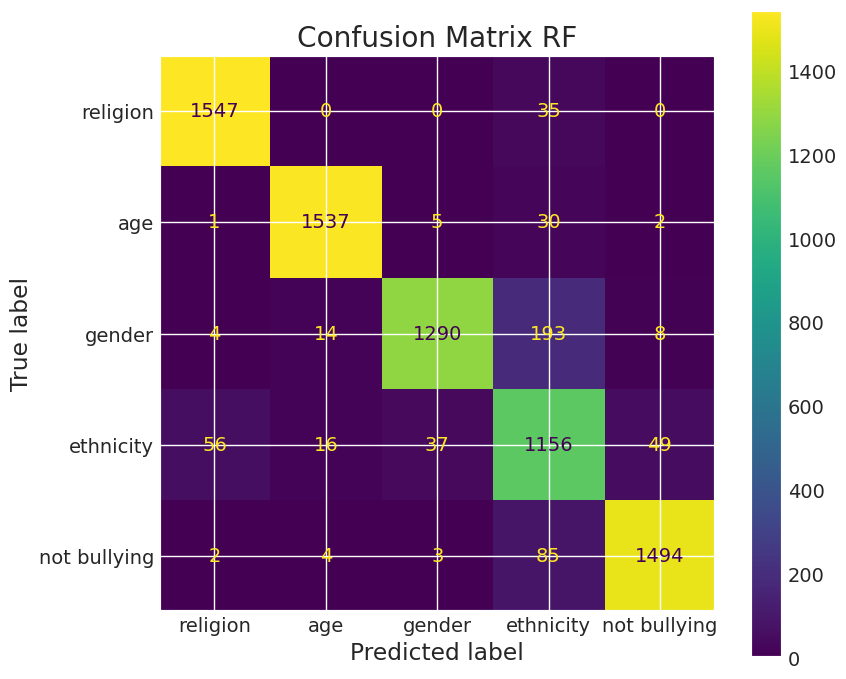

In [ ]:
# SVC
cm = confusion_matrix(y_test,svc_pred)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(cm, display_labels=sentiments)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.title("Confusion Matrix RF")
plt.show()